In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist

Using TensorFlow backend.
/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ggj/a

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2 # 隐变量取2维只是为了方便后面画图
intermediate_dim = 256
epochs = 50

In [6]:
# 加载MNIST数据集
(x_train, y_train_), (x_test, y_test_) = mnist.load_data(path="/home/ggj/jiaqiLi/mount-1/ggj/.keras/datasets/mnist.npz")
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape, x_test.shape

In [7]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

In [ ]:
# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [8]:
# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [9]:
# 解码层，也就是生成器部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [10]:
# 建立模型
vae = Model(x, x_decoded_mean)

In [11]:
# xent_loss是重构loss，kl_loss是KL loss
xent_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=-1)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
____________________________________________________________________________________________

/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_5.
  'be expecting any data to be passed to {0}.'.format(name))


In [13]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 94us/step - loss: 190.1990 - val_loss: 172.3997
Epoch 2/50
60000/60000 [==============================] - 3s 58us/step - loss: 170.2356 - val_loss: 168.0530
Epoch 3/50
60000/60000 [==============================] - 3s 56us/step - loss: 166.9103 - val_loss: 166.0725
Epoch 4/50
60000/60000 [==============================] - 3s 57us/step - loss: 164.8085 - val_loss: 164.1428
Epoch 5/50
60000/60000 [==============================] - 3s 58us/step - loss: 163.2613 - val_loss: 163.0230
Epoch 6/50
60000/60000 [==============================] - 3s 57us/step - loss: 162.0313 - val_loss: 161.9291
Epoch 7/50
60000/60000 [==============================] - 3s 57us/step - loss: 160.9291 - val_loss: 160.6089
Epoch 8/50
60000/60000 [==============================] - 3s 56us/step - loss: 159.9096 - val_loss: 160.0422
Epoch 9/50
60000/60000 [==============================] - 3s 58us/step - loss

In [22]:
# 构建encoder，然后观察各个数字在隐空间的分布
encoder = Model(x, z_mean)

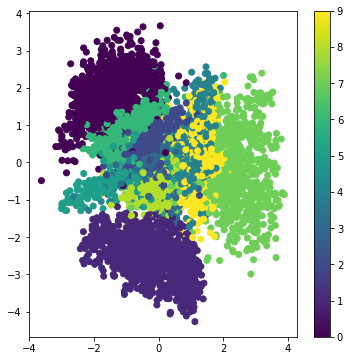

In [23]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_)
plt.colorbar()
plt.show()

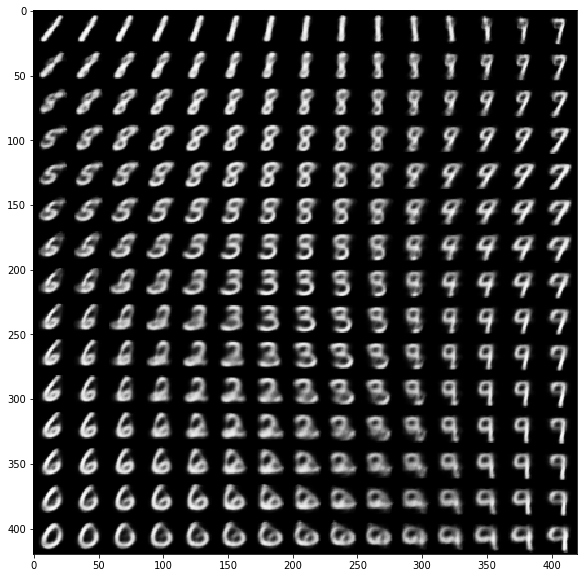

In [16]:
# 构建生成器
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# 观察隐变量的两个维度变化是如何影响输出结果的
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

#用正态分布的分位数来构建隐变量对
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()